In [1]:
# Watch for any changes in vocabulary.py, data_loader.py, utils.py or model.py, and re-load it automatically.
%load_ext autoreload
%autoreload 2

In [2]:
%reload_ext autoreload

In [5]:
import torch
import torch.nn as nn
from torch.autograd import Variable
from torchvision import transforms
import sys
from pycocotools.coco import COCO
import math
import torch.utils.data as data
import numpy as np
import os
import requests
import time

from utils import train, validate, save_epoch, early_stopping
from data_loader import get_loader
from model import EncoderCNN, DecoderRNN

In [6]:
# Set values for the training variables
batch_size = 32         # batch size
vocab_threshold = 5     # minimum word count threshold
vocab_from_file = True  # if True, load existing vocab file
embed_size = 256        # dimensionality of image and word embeddings
hidden_size = 512       # number of features in hidden state of the RNN decoder
num_epochs = 10          # number of training epochs

# Define a transform to pre-process the training images
transform_train = transforms.Compose([ 
    transforms.Resize(256),                          # smaller edge of image resized to 256
    transforms.RandomCrop(224),                      # get 224x224 crop from random location
    transforms.RandomHorizontalFlip(),               # horizontally flip image with probability=0.5
    transforms.ToTensor(),                           # convert the PIL Image to a tensor
    transforms.Normalize((0.485, 0.456, 0.406),      # normalize image for pre-trained model
                         (0.229, 0.224, 0.225))])

# Define a transform to pre-process the validation images
transform_val = transforms.Compose([ 
    transforms.Resize(256),                          # smaller edge of image resized to 256
    transforms.CenterCrop(224),                      # get 224x224 crop from the center
    transforms.ToTensor(),                           # convert the PIL Image to a tensor
    transforms.Normalize((0.485, 0.456, 0.406),      # normalize image for pre-trained model
                         (0.229, 0.224, 0.225))])

# Build data loader, applying the transforms
train_loader = get_loader(transform=transform_train,
                         mode='train',
                         batch_size=batch_size,
                         vocab_threshold=vocab_threshold,
                         vocab_from_file=vocab_from_file)
val_loader = get_loader(transform=transform_val,
                         mode='val',
                         batch_size=batch_size,
                         vocab_threshold=vocab_threshold,
                         vocab_from_file=vocab_from_file)


# The size of the vocabulary
vocab_size = len(train_loader.dataset.vocab)

Vocabulary successfully loaded from vocab.pkl file!
loading annotations into memory...
Done (t=0.61s)
creating index...


100%|██████████| 828/828 [00:00<00:00, 8282.00it/s]

index created!
length of ids  828
Obtaining caption lengths...
Vocabulary successfully loaded from vocab.pkl file!
loading annotations into memory...



100%|██████████| 405/405 [00:00<00:00, 8259.27it/s]

Done (t=0.45s)
creating index...
index created!
length of ids  405
Obtaining caption lengths...


In [ ]:
# Initialize the encoder and decoder
encoder = EncoderCNN(embed_size, architecture='resnet50')
# encoder = EncoderCNN(embed_size, architecture='densenet161')
decoder = DecoderRNN(embed_size, hidden_size, vocab_size)

# Move models to GPU if CUDA is available
if torch.cuda.is_available():
    encoder.cuda()
    decoder.cuda()
    
# Define the loss function
criterion = nn.CrossEntropyLoss().cuda() if torch.cuda.is_available() else nn.CrossEntropyLoss()

# Specify the learnable parameters of the model
params = list(decoder.parameters()) + list(encoder.embed.parameters()) + list(encoder.bn.parameters())

# Define the optimizer
optimizer = torch.optim.Adam(params=params, lr=0.001)

# Set the total number of training and validation steps per epoch
total_train_step = math.ceil(len(train_loader.dataset.caption_lengths) / train_loader.batch_sampler.batch_size)
total_val_step = math.ceil(len(val_loader.dataset.caption_lengths) / val_loader.batch_sampler.batch_size)
print ("Number of training steps:", total_train_step)
print ("Number of validation steps:", total_val_step)

In [ ]:
model_dir = './models/densenet161'
if not os.path.exists(model_dir):
    os.makedirs(model_dir)

# Keep track of train and validation losses and validation Bleu-4 scores by epoch
train_losses = []
val_losses = []
val_bleus = []
# Keep track of the current best validation Bleu score
best_val_bleu = float("-INF")

start_time = time.time()
for epoch in range(1, num_epochs + 1):
    train_loss = train(train_loader, encoder, decoder, criterion, optimizer, 
                       vocab_size, epoch, total_train_step)
    train_losses.append(train_loss)
    val_loss, val_bleu = validate(val_loader, encoder, decoder, criterion,
                                  train_loader.dataset.vocab, epoch, total_val_step)
    val_losses.append(val_loss)
    val_bleus.append(val_bleu)
    if val_bleu > best_val_bleu:
        print ("Validation Bleu-4 improved from {:0.4f} to {:0.4f}, saving model to best-model.pkl".
               format(best_val_bleu, val_bleu))
        best_val_bleu = val_bleu
        filename = os.path.join("./models", "best-model.pkl")
        save_epoch(filename, encoder, decoder, optimizer, train_losses, val_losses, 
                   val_bleu, val_bleus, epoch)
    else:
        print ("Validation Bleu-4 did not improve, saving model to model-{}.pkl".format(epoch))
    # Save the entire model anyway, regardless of being the best model so far or not
    filename = os.path.join("./models", "model-{}.pkl".format(epoch))
    save_epoch(filename, encoder, decoder, optimizer, train_losses, val_losses, 
               val_bleu, val_bleus, epoch)
    print ("Epoch [%d/%d] took %ds" % (epoch, num_epochs, time.time() - start_time))
    if epoch > 5:
        # Stop if the validation Bleu doesn't improve for 3 epochs
        if early_stopping(val_bleus, 3):
            break
    start_time = time.time()

In [11]:
def vis_training(train_points, val_points, num_epochs=0, loss=True, **kwargs):
    """ Visualize losses and accuracies w.r.t each epoch
    Args:
        num_epochs: (int) Number of epochs
        train_points: (list) Points of the training curve
        val_points: (list) Points of the validation curve
        loss: (bool) Flag for loss or accuracy. Defaulted to True for loss
    """
    import matplotlib.pyplot as plt
    import os
    
    # Check if nan values in data points
    train_points = [i for i in train_points if not math.isnan(i)]
    val_points = [i for i in val_points if not math.isnan(i)]
    num_epochs = len(train_points)
    x = np.arange(0, num_epochs)

    plt.plot(x, train_points, 'b')
    plt.plot(x, val_points, 'r')

    title = '{} vs Number of Epochs'.format('Loss' if loss else 'Accuracy')
    if 'EXP' in kwargs:
        title += ' (EXP: {})'.format(kwargs['EXP'])
    plt.title(title)

    if loss:
        plt.ylabel('Cross Entropy Loss')
    else:
        plt.ylabel('Accuracy')

    plt.gca().legend(('Train', 'Val'))
    plt.xlabel('Number of Epochs')

    if not os.path.exists('figs'):
        os.makedirs('figs')

    save_path = './figs/train_val_{}'.format('loss' if loss else 'accuracy')
    for k_, v_ in kwargs.items():
        save_path += '_%s' % v_
    save_path += '.png'

    plt.savefig(save_path)
    plt.show()

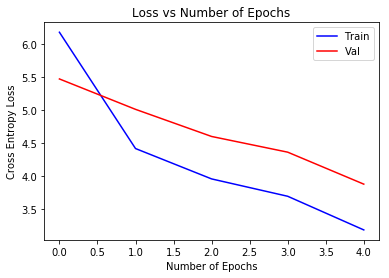

In [13]:
val_losses.append(3.8743)
vis_training(train_losses, val_losses, num_epochs=5)